# Predicting Student Admissions with Neural Networks in Keras
In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

## Loading the data
To load the data and format it nicely, we will use two very useful packages called Pandas and Numpy. You can read on the documentation here:
- https://pandas.pydata.org/pandas-docs/stable/
- https://docs.scipy.org/

In [1]:
# Importing pandas and numpy
import pandas as pd
import numpy as np

# Reading the csv file into a pandas DataFrame
data = pd.read_csv('student_data.csv')

# Printing out the first 10 rows of our data
data[:10]

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


## Plotting the data

First let's make a plot of our data to see how it looks. In order to have a 2D plot, let's ingore the rank.

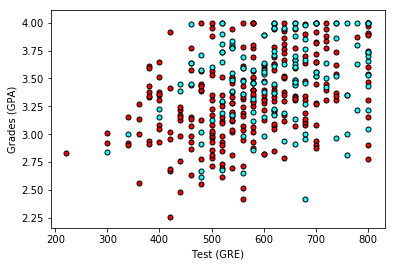

In [14]:
# Importing matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Function to help us plot
def plot_points(data):
    X = np.array(data[["gre","gpa"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
# Plotting the points
plot_points(data)
plt.show()

Roughly, it looks like the students with high scores in the grades and test passed, while the ones with low scores didn't, but the data is not as nicely separable as we hoped it would. Maybe it would help to take the rank into account? Let's make 4 plots, each one for each rank.

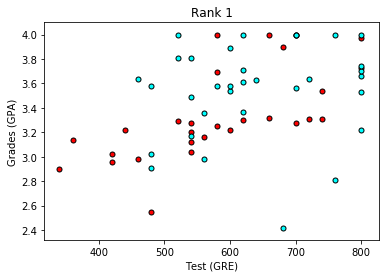

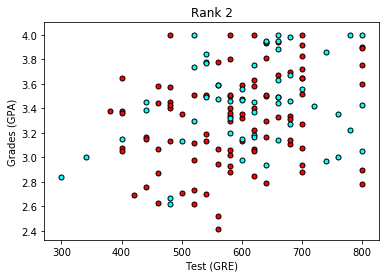

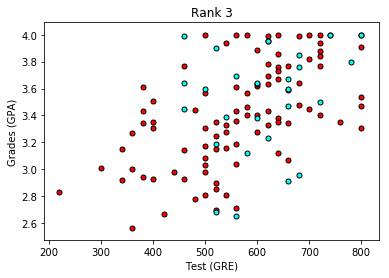

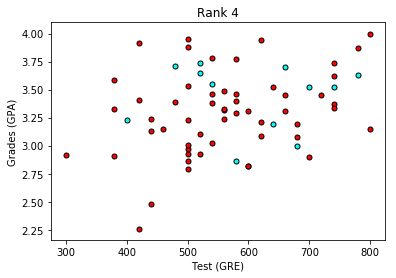

In [15]:
# Separating the ranks
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

# Plotting the graphs
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

This looks more promising, as it seems that the lower the rank, the higher the acceptance rate. Let's use the rank as one of our inputs. In order to do this, we should one-hot encode it.

## One-hot encoding the rank
For this, we'll use the `get_dummies` function in pandas.

In [16]:
# Make dummy variables for rank
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)

# Drop the previous rank column
one_hot_data = one_hot_data.drop('rank', axis=1)

# Print the first 10 rows of our data
one_hot_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1
5,1,760,3.00,0,1,0,0
6,1,560,2.98,1,0,0,0
7,0,400,3.08,0,1,0,0
8,1,540,3.39,0,0,1,0
9,0,700,3.92,0,1,0,0


## Scaling the data
The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to handle. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [17]:
# Copying our data
processed_data = one_hot_data[:]

# Scaling the columns
processed_data['gre'] = processed_data['gre']/800
processed_data['gpa'] = processed_data['gpa']/4.0
processed_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0
3,1,0.800,0.7975,0,0,0,1
4,0,0.650,0.7325,0,0,0,1
5,1,0.950,0.7500,0,1,0,0
6,1,0.700,0.7450,1,0,0,0
7,0,0.500,0.7700,0,1,0,0
8,1,0.675,0.8475,0,0,1,0
9,0,0.875,0.9800,0,1,0,0


## Splitting the data into Training and Testing

In order to test our algorithm, we'll split the data into a Training and a Testing set. The size of the testing set will be 10% of the total data.

In [18]:
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 360
Number of testing samples is 40
     admit    gre     gpa  rank_1  rank_2  rank_3  rank_4
80       0  0.875  0.7250       0       0       0       1
118      1  1.000  0.9250       1       0       0       0
145      0  0.475  0.8575       0       0       1       0
43       0  0.625  0.8275       0       0       1       0
175      1  0.775  0.8425       0       1       0       0
32       0  0.750  0.8500       0       0       1       0
198      0  0.750  0.9075       0       0       1       0
48       0  0.550  0.6200       0       0       0       1
117      0  0.875  0.9300       0       1       0       0
65       0  0.750  0.8975       0       1       0       0
    admit    gre     gpa  rank_1  rank_2  rank_3  rank_4
1       1  0.825  0.9175       0       0       1       0
9       0  0.875  0.9800       0       1       0       0
18      0  1.000  0.9375       0       1       0       0
25      1  1.000  0.9150       1       0       0       0
35      0  

## Splitting the data into features and targets (labels)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

Also, in Keras, we need to one-hot encode the output. We'll do this with the `to_categorical function`.

In [19]:
import keras

# Separate data and one-hot encode the output
# Note: We're also turning the data into numpy arrays, in order to train the model in Keras
features = np.array(train_data.drop('admit', axis=1))
targets = np.array(keras.utils.to_categorical(train_data['admit'], 2))
features_test = np.array(test_data.drop('admit', axis=1))
targets_test = np.array(keras.utils.to_categorical(test_data['admit'], 2))

print(features[:10])
print(targets[:10])

[[ 0.875   0.725   0.      0.      0.      1.    ]
 [ 1.      0.925   1.      0.      0.      0.    ]
 [ 0.475   0.8575  0.      0.      1.      0.    ]
 [ 0.625   0.8275  0.      0.      1.      0.    ]
 [ 0.775   0.8425  0.      1.      0.      0.    ]
 [ 0.75    0.85    0.      0.      1.      0.    ]
 [ 0.75    0.9075  0.      0.      1.      0.    ]
 [ 0.55    0.62    0.      0.      0.      1.    ]
 [ 0.875   0.93    0.      1.      0.      0.    ]
 [ 0.75    0.8975  0.      1.      0.      0.    ]]
[[ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


## Defining the model architecture
Here's where we use Keras to build our neural network.

In [20]:
# Imports
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

# Building the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(6,)))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(2, activation='softmax'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               896       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 9,282.0
Trainable params: 9,282.0
Non-trainable params: 0.0
_________________________________________________________________


## Training the model

In [22]:
# Training the model
model.fit(features, targets, epochs=200, batch_size=100, verbose=1)

Epoch 1/200
360/360 [==============================] - 0s - loss: 0.5585 - acc: 0.7250     
Epoch 2/200
360/360 [==============================] - 0s - loss: 0.5570 - acc: 0.7222     
Epoch 3/200
360/360 [==============================] - 0s - loss: 0.5660 - acc: 0.7083     
Epoch 4/200
360/360 [==============================] - 0s - loss: 0.5566 - acc: 0.7083     
Epoch 5/200
360/360 [==============================] - 0s - loss: 0.5586 - acc: 0.7083     
Epoch 6/200
360/360 [==============================] - 0s - loss: 0.5663 - acc: 0.7167     
Epoch 7/200
360/360 [==============================] - 0s - loss: 0.5560 - acc: 0.7167     
Epoch 8/200
360/360 [==============================] - 0s - loss: 0.5644 - acc: 0.7222     
Epoch 9/200
360/360 [==============================] - 0s - loss: 0.5595 - acc: 0.7056     
Epoch 10/200
360/360 [==============================] - 0s - loss: 0.5610 - acc: 0.7222     
Epoch 11/200
360/360 [==============================] - 0s - loss: 0.5632 - acc

360/360 [==============================] - 0s - loss: 0.5520 - acc: 0.7139     
Epoch 90/200
360/360 [==============================] - 0s - loss: 0.5552 - acc: 0.7111     
Epoch 91/200
360/360 [==============================] - 0s - loss: 0.5561 - acc: 0.7194     
Epoch 92/200
360/360 [==============================] - 0s - loss: 0.5481 - acc: 0.7000     
Epoch 93/200
360/360 [==============================] - 0s - loss: 0.5565 - acc: 0.7167     
Epoch 94/200
360/360 [==============================] - 0s - loss: 0.5448 - acc: 0.7222     
Epoch 95/200
360/360 [==============================] - 0s - loss: 0.5572 - acc: 0.7167     
Epoch 96/200
360/360 [==============================] - 0s - loss: 0.5495 - acc: 0.7194     
Epoch 97/200
360/360 [==============================] - 0s - loss: 0.5528 - acc: 0.7222     
Epoch 98/200
360/360 [==============================] - 0s - loss: 0.5536 - acc: 0.7111     
Epoch 99/200
360/360 [==============================] - 0s - loss: 0.5534 - acc: 0.

360/360 [==============================] - 0s - loss: 0.5511 - acc: 0.7194     
Epoch 177/200
360/360 [==============================] - 0s - loss: 0.5476 - acc: 0.7083     
Epoch 178/200
360/360 [==============================] - 0s - loss: 0.5479 - acc: 0.7111     
Epoch 179/200
360/360 [==============================] - 0s - loss: 0.5480 - acc: 0.7333     
Epoch 180/200
360/360 [==============================] - 0s - loss: 0.5477 - acc: 0.7278     
Epoch 181/200
360/360 [==============================] - 0s - loss: 0.5533 - acc: 0.7278     
Epoch 182/200
360/360 [==============================] - 0s - loss: 0.5558 - acc: 0.7194     
Epoch 183/200
360/360 [==============================] - 0s - loss: 0.5456 - acc: 0.7250     
Epoch 184/200
360/360 [==============================] - 0s - loss: 0.5530 - acc: 0.7167     
Epoch 185/200
360/360 [==============================] - 0s - loss: 0.5495 - acc: 0.7194     
Epoch 186/200
360/360 [==============================] - 0s - loss: 0.5559

## Scoring the model

In [23]:
# Evaluating the model on the training and testing set
score = model.evaluate(features, targets)
print("\n Training Accuracy:", score[1])
score = model.evaluate(features_test, targets_test)
print("\n Testing Accuracy:", score[1])

 32/360 [=>............................] - ETA: 0s
 Training Accuracy: 0.727777777778
32/40 [=======================>......] - ETA: 0s
 Testing Accuracy: 0.625


## Challenge: Play with the parameters!
You can see that we made several decisions in our training. For instance, the number of layers, the sizes of the layers, the number of epochs, etc.
It's your turn to play with parameters! Can you improve the accuracy? The following are other suggestions for these parameters. We'll learn the definitions later in the class:
- Activation function: relu and sigmoid
- Loss function: categorical_crossentropy, mean_squared_error
- Optimizer: rmsprop, adam, ada